In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from music21 import *

print(torch.__version__)

1.3.1


In [2]:
def default_device():
    if torch.cuda.is_available()==True:
        dflt_device = torch.device('cuda')
    else:
        dflt_device = torch.device('cpu')

    return dflt_device


def dimensions(E,S): 
    num_event_examples, num_events , event_emb_size  = E.shape    
    num_seq_examples = len(S)
    signal_emb_size = S[0].size(1)
    
    dims = [num_event_examples, num_events , event_emb_size, num_seq_examples, signal_emb_size ]
    
    return dims


def net_generate(e, sample=False):
    event_steps = e.shape[0]
    encoded_conditioning = event_forward_pass(e.view(1, event_steps, -1))
    #signal_h_ini = (torch.zeros(num_signal_layers, num_signal_examples, signal_hidden_size).to(device=dflt_device),\
              #torch.zeros(num_signal_layers, num_signal_examples, signal_hidden_size).to(device=dflt_device) )
    #hidden = (signal_h_ini[0][0,0,:].view(num_signal_layers, 1, signal_hidden_size), \
           #signal_h_ini[1][0,0,:].view(num_signal_layers, 1, signal_hidden_size))
    hidden = (torch.zeros(num_signal_layers, 1, signal_hidden_size).to(device=dflt_device),\
              torch.zeros(num_signal_layers, 1, signal_hidden_size).to(device=dflt_device) )
    signal_prev = torch.zeros(1, signal_emb_size).to(device=dflt_device)
    prediction_list     = []
    raw_prediction_list = []
    cumulative_duration = 0
    while cumulative_duration <= float(event_steps-1):
        dynamic_idx = int(cumulative_duration)
        conditioning = encoded_conditioning[0, dynamic_idx, :].view(1,-1)
        signal_input = torch.cat((signal_prev, conditioning), dim=1)
        signal_input = signal_input.view(1,1,-1)
        s_hat_pre, hidden = signal_forward_pass(signal_input, hidden )
        #s_hat = torch.sigmoid(s_hat)  #smoothens the future prob dist
        s_hat_pitch  = F.softmax( s_hat_pre[0, 0, 0:rhythm_idx_ini], dim = 0 )
        s_hat_rhythm = F.softmax( s_hat_pre[0, 0, rhythm_idx_ini:], dim = 0 )

        raw_s_hat = torch.cat ((s_hat_pitch, s_hat_rhythm), dim = 0).view(1,-1)
        raw_prediction_list.append(raw_s_hat)        

        if sample == False:
            note_max , note_argmax = s_hat_pitch.max(0)
            rhythm_max , rhythm_argmax = s_hat_rhythm.max(0)

        if sample == True:
            note_prob_dist = torch.distributions.Categorical(s_hat_pitch)
            note_argmax = int(note_prob_dist.sample())
            rhythm_prob_dist = torch.distributions.Categorical(s_hat_rhythm)
            rhythm_argmax = int(rhythm_prob_dist.sample())
            #rhythm_max , rhythm_argmax = s_hat_rhythm.max(0)

        s_hat = torch.zeros(1, signal_emb_size)
        s_hat[0, int(note_argmax)] = 1  
        s_hat[0, int(rhythm_idx_ini + int(rhythm_argmax))] = 1                    
        prediction_list.append(s_hat)

        #pitch_idx, rhythm_idx = list((s_hat != 0).nonzero())
        #pitch_idx, rhythm_idx = int(pitch_idx), int(rhythm_idx)
        #duration_type_idx = rhythm_argmax - rhythm_idx_ini
        duration_type = durations_list[rhythm_argmax]
        cumulative_duration += duration_type

        signal_prev  = s_hat.to(device=dflt_device)

    prediction = torch.cat(prediction_list)
    raw_prediction = torch.cat(raw_prediction_list)

    return prediction , raw_prediction


def vect2note(vector):
    note_embedding_size = signal_emb_size 
    assert np.shape(vector) == (note_embedding_size,)
    duration_idx = int(np.argwhere(vector[rhythm_idx_ini:]))
    duration = durations_list[duration_idx]
    
    if vector[rhythm_idx_ini-1] == 1:
        nota = note.Rest()
        nota.quarterLength = duration
    else:
        height = int(np.argwhere(vector[:rhythm_idx_ini-1])) + min_pitch
        nota = note.Note()
        nota.pitch.midi = height
        nota.quarterLength = duration
    
    return nota


def matrix2melody(melodyMatrix):
    m,n = melodyMatrix.shape
    melodyStream = stream.Stream()
    
    #To impose a time and key signature:
    melodyStream.timeSignature = meter.TimeSignature('4/4')
    melodyStream.keySignature = key.Key('C')
    
    for i in range(n):
        vector = melodyMatrix[:,i]
        nota = vect2note(vector)
        melodyStream.append(nota)
        melody = melodyStream.stripTies()
        
    return melody


def enter_progression(event_emb_size, beats_per_measure=4):
    
    chord_vect_size = event_emb_size
    progression_matrix  = np.zeros([0, chord_vect_size])
    progression_symbols = []
    chord_list = []
    
    print('How many bars long is your progression? (enter an integer): ')
    bars = int(input()) 
    total_beats = beats_per_measure * bars    
    for beat in range(0, total_beats):                              
        progression_symbols.append('?')
    
    progression_display = ''    
    progression_display_length = total_beats + bars + 1
    temp_display = progression_symbols[:]    
    for i in range(0, progression_display_length, 5):                                      
        temp_display.insert(i,'|')        
                                                  
    for i in range(len(temp_display)):
        progression_display += temp_display[i] + ' '
        
    print('Progression status: ' + progression_display )
    
    counter = 0
    while True:
        chord_vector = np.zeros([1, chord_vect_size])
        
        print('Enter a chord:')
        chord_name = str(input())
        
        print('How many beats of that chord?')
        chord_duration = int(input())
        total_duration = counter + chord_duration
        if total_duration > total_beats:
            break
        else:
            chord = harmony.ChordSymbol(chord_name)
            chord.quarterLength = chord_duration
            chord_list.append(chord)
           
            root_idx       = chord.root().midi % 12
            chord_pitches  = [p.midi for p in chord.pitches]
            chord_vector[0,root_idx] = 1
            for i, chord_pitch in enumerate(chord_pitches):
                chord_pitch_idx = chord_pitch % 12
                chord_vector[0, 12 + chord_pitch_idx] = 1
            for j in range(chord_duration):
                progression_matrix = np.append(progression_matrix, chord_vector, axis=0)
                
            for i in range(counter, total_duration):
                progression_symbols[i] = chord_name              
            temp_display = progression_symbols[:] 
            
            for i in range(0, progression_display_length, 5):                                      
                temp_display.insert(i,'|')
                
            progression_display = ''
            for i in range(len(temp_display)):
                progression_display += temp_display[i] + ' '
                
            print('Progression: ' + progression_display)
            counter = total_duration
            if counter == total_beats:
                break
            else:
                continue
            
    chord_matrix = torch.from_numpy(progression_matrix)
    chord_matrix = chord_matrix.type(torch.FloatTensor)
        
    return progression_display , chord_matrix , chord_list


def predict_new(chord_matrix, chord_list, sample=False):
    
    solo_prediction, raw_prediction = net_generate(chord_matrix, sample)
    solo_prediction = solo_prediction.transpose(0,1)
    raw_prediction = raw_prediction.transpose(0,1)
    solo_prediction = solo_prediction.numpy()
    raw_prediction = raw_prediction.detach().numpy()
      
    solo = matrix2melody(solo_prediction)    
    
    chord_sounds = stream.Stream()
    for acorde in chord_list:
        acorde.writeAsChord = True
        chord_sounds.append(acorde)
        
    solo_with_chords = stream.Score()
    solo_with_chords.insert(0, solo)
    solo_with_chords.insert(0, chord_sounds)
    
    return solo_with_chords, solo_prediction , raw_prediction

In [3]:
class event_net(torch.nn.Module):
    
    def __init__(self, event_emb_size, event_hidden_size, event_output_size, \
                 num_event_layers, num_event_examples, num_directions):
        super(event_net, self).__init__()

        self.event_emb_size     = event_emb_size
        self.event_hidden_size  = event_hidden_size
        self.event_output_size  = event_output_size
        self.num_event_layers   = num_event_layers
        self.num_event_examples = num_event_examples
        self.num_directions     = num_directions
        
        self.event_lstm   = torch.nn.LSTM(self.event_emb_size, self.event_hidden_size, \
                                    self.num_event_layers, batch_first=True, bidirectional=True)
        self.event_linear = torch.nn.Linear(self.event_hidden_size*num_directions, self.event_output_size)
        
        self.initHidden  = self.init_hidden()
    
    def init_hidden(self):
        h_ini = (torch.zeros(self.num_event_layers*num_directions, self.num_event_examples, self.event_hidden_size),\
              torch.zeros(self.num_event_layers*num_directions, self.num_event_examples, self.event_hidden_size) )
          
    def forward(self, Events):
        event_lstm_out, event_hidden = self.event_lstm(Events, self.initHidden)
        linear_output = self.event_linear(event_lstm_out*num_event_layers)
        event_output = torch.sigmoid(linear_output)
        
        return event_output #event_lstm_out


class signal_net(torch.nn.Module):
    def __init__(self, signal_emb_size, conditioning_size, signal_hidden_size, \
                 signal_output_size, num_signal_layers, num_signal_examples):
        super(signal_net, self).__init__()
        
        self.signal_emb_size     = signal_emb_size
        self.conditioning_size   = conditioning_size
        self.signal_hidden_size  = signal_hidden_size
        self.signal_output_size  = signal_output_size
        self.num_signal_layers   = num_signal_layers
        self.num_signal_examples = num_signal_examples
        
        self.signal_lstm   = torch.nn.LSTM(self.signal_emb_size+self.conditioning_size, self.signal_hidden_size, \
                                    self.num_signal_layers, batch_first=True)
        self.signal_linear = torch.nn.Linear(self.signal_hidden_size, self.signal_output_size)
        
    def forward(self, S_input, prev_hidden):
        signal_lstm_out, signal_hidden = self.signal_lstm(S_input, prev_hidden)
        signal_linear_output = self.signal_linear(signal_lstm_out.data)
        #signal_output = torch.sigmoid(signal_linear_output)
        
        return signal_linear_output, signal_hidden


In [31]:
dflt_device = default_device()

E, S, durations_list, min_pitch, max_pitch = torch.load('Parker_Dataset.pt')
num_event_examples, num_events , event_emb_size, num_signal_examples, signal_emb_size = dimensions(E,S)
rhythm_idx_ini = max_pitch - min_pitch + 1 + True

hyperparameters, event_forward_pass_parameters, signal_forward_pass_parameters \
= torch.load('model_parameters.pt', map_location=torch.device('cpu'))

num_event_layers   = hyperparameters['num_event_layers']
event_hidden_size  = hyperparameters['event_hidden_size']
num_directions     = hyperparameters['num_directions']
event_output_size  = hyperparameters['event_output_size']
num_signal_layers  = hyperparameters['num_signal_layers']
signal_hidden_size = hyperparameters['signal_hidden_size']
signal_output_size = hyperparameters['signal_output_size']
conditioning_size  = hyperparameters['conditioning_size']

event_forward_pass  = event_net(event_emb_size, event_hidden_size, event_output_size, \
                     num_event_layers, num_event_examples, num_directions)
signal_forward_pass = signal_net(signal_emb_size, conditioning_size, signal_hidden_size, \
                      signal_output_size, num_signal_layers, num_signal_examples)
event_forward_pass  = event_forward_pass.to(device=dflt_device)
signal_forward_pass = signal_forward_pass.to(device=dflt_device)

event_forward_pass.load_state_dict(event_forward_pass_parameters)
signal_forward_pass.load_state_dict(signal_forward_pass_parameters)

<All keys matched successfully>

In [33]:
progression_display , chord_matrix , chord_list = enter_progression(event_emb_size, beats_per_measure=4)

How many bars long is your progression? (enter an integer): 
2
Progression status: | ? ? ? ? | ? ? ? ? | 
Enter a chord:
Gm7
How many beats of that chord?
2
Progression: | Gm7 Gm7 ? ? | ? ? ? ? | 
Enter a chord:
C7
How many beats of that chord?
2
Progression: | Gm7 Gm7 C7 C7 | ? ? ? ? | 
Enter a chord:
F
How many beats of that chord?
4
Progression: | Gm7 Gm7 C7 C7 | F F F F | 


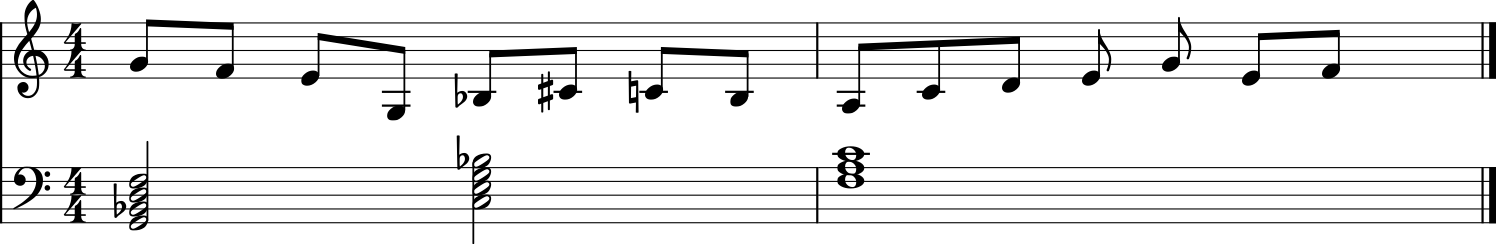

In [37]:
#chord_matrix = E[1,:,:]
solo, solo_prediction , raw_prediction = predict_new(chord_matrix, chord_list, sample=True)
solo.show()
solo.show('midi')

In [38]:
solo.write('xml', 'SoloSnips/generated_solo.xml')

'/Users/Amillo/Dropbox/Git-PRE/dynamic_solo/Experiments/Model_2_0/Exp1/SoloSnips/generated_solo_martin2.xml'